# PopulationSim Performance Monitor

This notebook runs the PopulationSim simulation script (`run_calm_mp.sh`) and monitors its CPU and memory usage in real-time.

In [1]:
import psutil
import subprocess
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
import datetime

# Set seaborn theme
sns.set_theme(style="whitegrid")

In [2]:
# Configuration
SCRIPT_PATH = "./run_calm_mp.sh"
INTERVAL = 0.5  # Seconds between checks

In [3]:
def monitor_simulation(script_path, interval=1.0):
    """
    Runs the simulation script and collects performance stats.
    """
    print(f"Starting simulation: {script_path}")
    # Start the process in a new session to monitoring easier
    process = subprocess.Popen(script_path, shell=True)
    
    pid = process.pid
    print(f"Parent Process ID: {pid}")
    
    stats = []
    start_time = time.time()
    
    try:
        ps_process = psutil.Process(pid)
        
        while process.poll() is None:
            current_time = datetime.datetime.now()
            elapsed = time.time() - start_time
            
            try:
                # Initialize totals
                total_cpu = 0.0
                total_mem_mb = 0.0
                
                # Get stats for the parent shell process (usually low)
                try:
                    total_cpu += ps_process.cpu_percent(interval=None)
                    total_mem_mb += ps_process.memory_info().rss / (1024 * 1024)
                except (psutil.NoSuchProcess, psutil.AccessDenied):
                    pass

                # Get stats for all child processes (the actual python workers)
                try:
                    children = ps_process.children(recursive=True)
                    for child in children:
                        try:
                            total_cpu += child.cpu_percent(interval=None)
                            total_mem_mb += child.memory_info().rss / (1024 * 1024)
                        except (psutil.NoSuchProcess, psutil.AccessDenied):
                            pass
                except (psutil.NoSuchProcess, psutil.AccessDenied):
                    # Process might have died during check
                    pass

                stats.append({
                    'timestamp': current_time,
                    'elapsed_sec': elapsed,
                    'cpu_percent': total_cpu,
                    'memory_mb': total_mem_mb,
                    'process_count': 1 + len(children) if 'children' in locals() else 1
                })
                
                # Simple text progress
                print(f"\rElapsed: {elapsed:.1f}s | CPU: {total_cpu:.1f}% | Mem: {total_mem_mb:.1f} MB | Procs: {stats[-1]['process_count']}", end="")
                
            except (psutil.NoSuchProcess, psutil.AccessDenied):
                break
            
            time.sleep(interval)
            
    except Exception as e:
        print(f"\nAn error occurred: {e}")
    finally:
        if process.poll() is None:
            print("\nTerminating process...")
            process.terminate()
            process.wait()
            
    return_code = process.wait()
    print(f"\n\nProcess finished with exit code: {return_code}")
    
    return pd.DataFrame(stats)

In [4]:
# Run the simulation
df_stats = monitor_simulation(SCRIPT_PATH, INTERVAL)

Starting simulation: ./run_calm_mp.sh
Parent Process ID: 71244
Elapsed: 1.0s | CPU: 0.4% | Mem: 100.8 MB | Procs: 2Configured logging using basicConfig
INFO:populationsim:Configured logging using basicConfig
INFO - Read logging configuration from: configs/logging.yaml
INFO - SETTING configs_dir: ['configs_mp', 'configs']
INFO - SETTING settings_file_name: settings.yaml
INFO - SETTING data_dir: data
INFO - SETTING output_dir: output_mp
INFO - SETTING multiprocess: True
INFO - SETTING num_processes: 2
INFO - SETTING resume_after: None
INFO - SETTING GROUP_BY_INCIDENCE_SIGNATURE: True
INFO - SETTING INTEGERIZE_WITH_BACKSTOPPED_CONTROLS: True
INFO - SETTING SUB_BALANCE_WITH_FLOAT_SEED_WEIGHTS: False
INFO - SETTING meta_control_data: None
INFO - SETTING control_file_name: controls.csv
INFO - SETTING USE_CVXPY: False
INFO - SETTING USE_SIMUL_INTEGERIZER: True
INFO - ENV MKL_NUM_THREADS: None
INFO - ENV OMP_NUM_THREADS: None
INFO - ENV OPENBLAS_NUM_THREADS: None
INFO - ENV NUMBA_NUM_THREADS: 

/Users/sunsun/Library/CloudStorage/GoogleDrive-chantapat.sun@gmail.com/My Drive/Study/Active-Based Model Simulator/populationsim/examples/example_calm/../../populationsim/core/input.py:231: DtypeWarning: Columns (219,221,225) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, comment="#", dtype=dtypes)


INFO - #run_model running step setup_data_structures
Running step 'setup_data_structures'
INFO - Reading control file configs/controls.csv
INFO - dropping 149 TAZ control rows with empty total_hh_control
INFO - dropped 0 households not in seed zones
INFO - kept 4839 households in seed zones
INFO - control target num_hh
INFO - control target hh_size_1
INFO - control target hh_size_2
INFO - control target hh_size_3
INFO - control target hh_size_4_plus
INFO - control target hh_age_15_24
INFO - control target hh_age_25_54
INFO - control target hh_age_55_64
INFO - control target hh_age_65_plus
INFO - control target hh_inc_15
INFO - control target hh_inc_15_30
INFO - control target hh_inc_30_60
INFO - control target hh_inc_60_plus
INFO - control target students_by_family_housing_type
INFO - control target students_by_nonfamily_housing_type
INFO - control target hh_wrks_0
INFO - control target hh_wrks_1
INFO - control target hh_wrks_2
INFO - control target hh_wrks_3_plus
INFO - control target

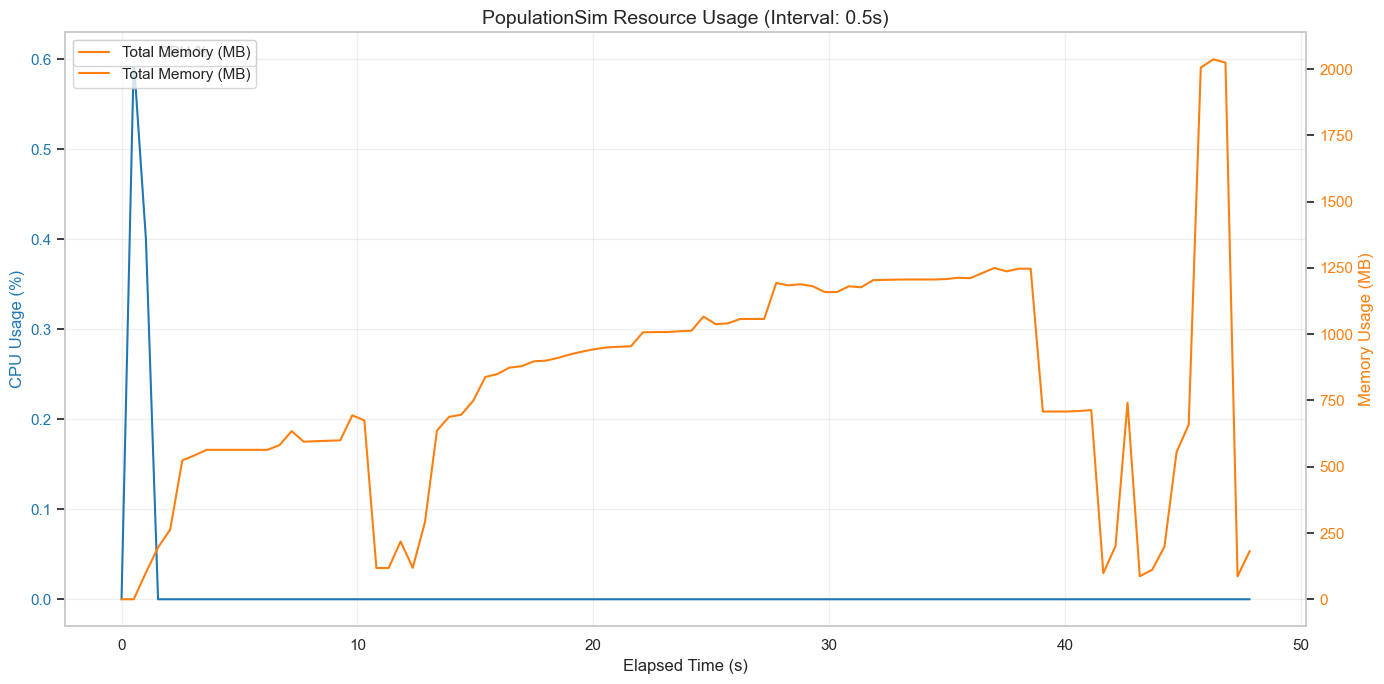

Summary Statistics:
Peak CPU Usage:    0.60 %
Peak Memory Usage: 2037.20 MB
Average CPU Usage: 0.01 %
Duration:          47.82 s


In [5]:
# Visualization
if not df_stats.empty:
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot CPU Usage
    color_cpu = 'tab:blue'
    ax1.set_xlabel('Elapsed Time (s)')
    ax1.set_ylabel('CPU Usage (%)', color=color_cpu, fontsize=12)
    sns.lineplot(data=df_stats, x='elapsed_sec', y='cpu_percent', ax=ax1, color=color_cpu, label='Total CPU %')
    ax1.tick_params(axis='y', labelcolor=color_cpu)
    ax1.grid(True, alpha=0.3)

    # Plot Memory Usage on secondary axis
    ax2 = ax1.twinx()  
    color_mem = 'tab:orange'
    ax2.set_ylabel('Memory Usage (MB)', color=color_mem, fontsize=12)  
    sns.lineplot(data=df_stats, x='elapsed_sec', y='memory_mb', ax=ax2, color=color_mem, label='Total Memory (MB)')
    ax2.tick_params(axis='y', labelcolor=color_mem)
    ax2.grid(False) # Turn off grid for second axis to catch visual clutter

    plt.title(f'PopulationSim Resource Usage (Interval: {INTERVAL}s)', fontsize=14)
    
    # Combined legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Summary Stats
    print("Summary Statistics:")
    print(f"Peak CPU Usage:    {df_stats['cpu_percent'].max():.2f} %")
    print(f"Peak Memory Usage: {df_stats['memory_mb'].max():.2f} MB")
    print(f"Average CPU Usage: {df_stats['cpu_percent'].mean():.2f} %")
    print(f"Duration:          {df_stats['elapsed_sec'].max():.2f} s")
else:
    print("No data collected.")